In [1]:
%matplotlib inline
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.font_manager as fm

font_prop = fm.FontProperties(fname='/home/starlightx/.local/share/fonts/MyFont.ttf')


def incidence_matrix(G, nodelist=None, edgelist=None,
        oriented=False, weight=None):
    import scipy.sparse
    if nodelist is None:
        nodelist = list(G)
    if edgelist is None:
        if G.is_multigraph():
            edgelist = list(G.edges(keys=True))
        else:
            edgelist = list(G.edges())
    A = scipy.sparse.lil_matrix((len(nodelist), len(edgelist)))
    node_index = dict((node, i) for i, node in enumerate(nodelist))
    for ei, e in enumerate(edgelist):
        (u, v) = e[:2]
        try:
            ui = node_index[u]
            vi = node_index[v]
        except KeyError:
            raise nx.NetworkXError('node %s or %s in edgelist '
                    'but not in nodelist' % (u, v))
            if weight is None:
                wt = 1
        else:
            if G.is_multigraph():
                ekey = e[2]
                wt = G[u][v][ekey].get(weight, 1)
            else:
                wt = G[u][v].get(weight, 1)
        if u == v:
            A[vi, ei] = 3
        elif oriented:
            A[ui, ei] = wt
            A[vi, ei] = -wt
        else:
            A[ui, ei] = wt
            A[vi, ei] = wt
    return A.asformat('csc')


def graph_from_adjacency_matrix(matr, t='G'):
    x_size = len(matr)
    y_size = len(matr[0])

    if x_size != y_size:
        raise Exception(
                'Matrix shape is: {}x{}\nMatrx should be square.'.format(x_size, y_size))

    if t == 'G':
        G = nx.Graph()
    elif t == 'MG':
        G = nx.MultiGraph()
    elif t == 'MDG':
        G = nx.MultiDiGraph()

    G.add_nodes_from(range(1, x_size + 1))

    for i, row in enumerate(matr):
        for j, col in enumerate(row):
            if col:
                G.add_edge(i + 1, j + 1)
    return G


def graph_from_incidence_matrix(matr, t='G'):
    cols = [[row[i]for row in matr] for i in range(len(matr[0]))]

    if t == 'G':
        G = nx.Graph()
    elif t == 'MG':
        G = nx.MultiGraph()
    elif t == 'MDG':
        G = nx.MultiDiGraph()

    G.add_nodes_from(range(1, len(matr) + 1))

    for n, col in enumerate(cols):
        if col.count(1) == col.count(-1) == 1 and col.count(0) == len(col) - 2:
            G.add_edge(col.index(1) + 1, col.index(-1) + 1)
        elif col.count(1) == 2 and col.count(0) == len(col) - 2:
            if t in ('MG', 'MDG'):
                G.add_edge(col.index(1) + 1, len(col) - col[::-1].index(1))
                G.add_edge(len(col) - col[::-1].index(1) - 1, col.index(1) + 1)
            else:
                G.add_edge(col.index(1) + 1, len(col) - col[::-1].index(1))
        elif col.count(0) == len(col) - 1 and len([i for i in col if i not in (0, 1, -1)]) == 1:
            non_zero = [n for n,i in enumerate(col) if i != 0][0] + 1
            G.add_edge(non_zero, non_zero)
        else:
            raise Exception('Incorrect column: {}\nOn pos: {}'.format(col, n))
    return G


def plot_graph(G, path='multi.png'):
    G.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curved', 'color': '#002366'}
    G.graph['graph'] = {'scale': '3'}
    G.graph['node'] = {'fontname': 'MyFont', 'fontsize': 25, 'fontcolor': '#002366', 'color': '#002366'}

    A = to_agraph(G)
    A.layout('dot')
    A.draw(path)

    
def union(V1, V2, E1, E2, t='MDG'):
    if t == 'G':
        G = nx.Graph()
    elif t == 'MG':
        G = nx.MultiGraph()
    elif t == 'MDG':
        G = nx.MultiDiGraph()
    G.add_nodes_from(V1|V2)  
    G.add_edges_from(E1 + E2)
    return G


def intersect(V1, V2, E1, E2, t='MDG'):
    if t == 'G':
        G = nx.Graph()
    elif t == 'MG':
        G = nx.MultiGraph()
    elif t == 'MDG':
        G = nx.MultiDiGraph()
    G.add_nodes_from(V1&V2)  
    G.add_edges_from([i for i in E1 if i in E2])
    return G


def circle_sum(V1, V2, E1, E2, t='MDG'):
    if t == 'G':
        G = nx.Graph()
    elif t == 'MG':
        G = nx.MultiGraph()
    elif t == 'MDG':
        G = nx.MultiDiGraph()
    G.add_nodes_from(V1|V2)  
    G.add_edges_from([i for i in E1 if i not in E2] + 
                            [i for i in E2 if i not in E1])
    return G


def full_join(V1, V2, E1, E2, t='MDG'):
    if t == 'G':
        G = nx.Graph()
    elif t == 'MG':
        G = nx.MultiGraph()
    elif t == 'MDG':
        G = nx.MultiDiGraph()
    G.add_nodes_from(V1|V2)
    G.add_edges_from(E1 + E2 + [(a, b) for a in V1 for b in V2 if a != b])
    return G


def mult(V1, V2, E1, E2, t='MDG'):
    if t == 'G':
        G = nx.Graph()
    elif t == 'MG':
        G = nx.MultiGraph()
    elif t == 'MDG':
        G = nx.MultiDiGraph()
    nodes = [(a, b) for a in V1 for b in V2]
    G.add_nodes_from(nodes)
    G.add_edges_from((node1, node2) for node1 in nodes 
                                          for node2 in nodes
                          if ((node1[0], node2[0]) in E1 and node1[1] == node2[1]) or
                             ((node1[1], node2[1]) in E2 and node1[0] == node2[0]))
    return G
    

'''
    Задание 1
'''
def exercise_1(V1, V2, E1, E2):
    V1 = set(V1)
    V2 = set(V2)
    
    G1 = nx.MultiDiGraph()
    G1.add_nodes_from(V1)
    G1.add_edges_from(E1)

    G2 = nx.MultiDiGraph()
    G2.add_nodes_from(V2)
    G2.add_edges_from(E2)

    fig, ax = plt.subplots(3, 2, figsize=(15, 15))
    fig.tight_layout(pad=6)

    plot_graph(G1, 'G1.png')
    img = mpimg.imread('G1.png')
    ax[0][0].text(0, 1, 'G1', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax[0][0].axis('off')
    ax[0][0].imshow(img)

    plot_graph(G2, 'G2.png')
    img = mpimg.imread('G2.png')
    ax[0][1].text(0, 1, 'G2', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax[0][1].axis('off')
    ax[0][1].imshow(img)

    G1_u_G2 = union(V1, V2, E1, E2)
    plot_graph(G1_u_G2, 'G1_U_G2.png')
    img = mpimg.imread('G1_U_G2.png')
    ax[1][0].text(0, 1, 'G1 объединение G2\n', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax[1][0].axis('off')
    ax[1][0].imshow(img)

    plot_graph(intersect(V1, V2, E1, E2), 'G1_I_G2.png')
    img = mpimg.imread('G1_I_G2.png')
    ax[1][1].text(0, 1, 'G1 пересечение G2\n', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax[1][1].axis('off')
    ax[1][1].imshow(img)

    plot_graph(circle_sum(V1, V2, E1, E2), 'G1_CS_G2.png')
    img = mpimg.imread('G1_CS_G2.png')
    ax[2][0].text(0, 1, 'G1 кольцевая сумма G2\n', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax[2][0].axis('off')
    ax[2][0].imshow(img)

    ax[2][1].axis('off')
    
    '''
        Построение матрицы смежности
    '''
    
    fig, ax = plt.subplots(figsize=(15, 2))
    ax.axis('off')
    ax.text(0, 1, 'Матрица смежности G1 объединение G2:', fontproperties=font_prop, size=35, color='#002366')
    pos = 0.2
    for row in nx.adjacency_matrix(G1_u_G2).toarray():
        pos += 0.2
        ax.text(0.2, 1 - pos, ''.join([str(int(i)).rjust(3) for i in row]),
                fontproperties=font_prop, size=35, color='#002366')
    
    '''
        Построение матрицы инцидентности
    '''
    
    fig, ax = plt.subplots(figsize=(15, 2))
    ax.axis('off')
    ax.text(0, 1, 'Матрица инцидентности G1 объединение G2:', fontproperties=font_prop, size=35, color='#002366')
    pos = 0.1
    for row in incidence_matrix(G1_u_G2, oriented=True).toarray():
        pos += 0.3
        ax.text(0, 1 - pos, ''.join([str(int(i)).rjust(6) for i in row]),
                fontproperties=font_prop, size=35, color='#002366')
    
#     print('Матрица смежности G1 ∪ G2:')
#     for row in nx.adjacency_matrix(G1_u_G2).toarray():
#         print(*[str(int(i)).rjust(3) for i in row])

#     print()

#     print('Матрица инцидентности G1 ∪ G2:')
#     for row in incidence_matrix(G1_u_G2, oriented=True).toarray():
#         print(*[str(int(i)).rjust(3) for i in row])


'''
    Задание 3
'''
def exercise_2(V1, V2, E1, E2):
    V1 = set(V1)
    V2 = set(V2)
    
    G1 = nx.MultiDiGraph()
    G1.add_nodes_from(V1)
    G1.add_edges_from(E1)

    G2 = nx.MultiDiGraph()
    G2.add_nodes_from(V2)
    G2.add_edges_from(E2)

    fig, ax = plt.subplots(3, 2, figsize=(15, 15))
    fig.tight_layout(pad=6)

    plot_graph(G1, 'G1.png')
    img = mpimg.imread('G1.png')
    ax[0][0].text(0, 1, 'G1', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax[0][0].axis('off')
    ax[0][0].imshow(img)

    plot_graph(G2, 'G2.png')
    img = mpimg.imread('G2.png')
    ax[0][1].text(0, 1, 'G2', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax[0][1].axis('off')
    ax[0][1].imshow(img)

    G1_u_G2 = union(V1, V2, E1, E2)
    plot_graph(G1_u_G2, 'G1_U_G2.png')
    img = mpimg.imread('G1_U_G2.png')
    ax[1][0].text(0, 1, 'G1 объединение G2\n', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax[1][0].axis('off')
    ax[1][0].imshow(img)

    plot_graph(intersect(V1, V2, E1, E2), 'G1_I_G2.png')
    img = mpimg.imread('G1_I_G2.png')
    ax[1][1].text(0, 1, 'G1 пересечение G2\n', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax[1][1].axis('off')
    ax[1][1].imshow(img)

    plot_graph(circle_sum(V1, V2, E1, E2), 'G1_CS_G2.png')
    img = mpimg.imread('G1_CS_G2.png')
    ax[2][0].text(0, 1, 'G1 кольцевая сумма G2\n', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax[2][0].axis('off')
    ax[2][0].imshow(img)
    
    plot_graph(full_join(V1, V2, E1, E2), 'G1_SUM_G2.png')
    img = mpimg.imread('G1_SUM_G2.png')
    ax[2][1].text(0, 1, 'G1 + G2\n', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax[2][1].axis('off')
    ax[2][1].imshow(img)
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    plot_graph(mult(V1, V2, E1, E2), 'G1_MUL_G2.png')
    img = mpimg.imread('G1_MUL_G2.png')
    ax.text(0, 1, 'G1 * G2\n', 
                  fontproperties=font_prop, size=25, color='#002366')
    ax.axis('off')
    ax.imshow(img);

    
'''
    Задание 3
'''
def exercise_3(V1, V2, E1, E2):
    V1 = set(V1)
    V2 = set(V2)
    
    G1 = nx.Graph()
    G1.add_nodes_from(V1)
    G1.add_edges_from(E1)

    G2 = nx.Graph()
    G2.add_nodes_from(V2)
    G2.add_edges_from(E2)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    plot_graph(G1, 'G1.png')
    img = mpimg.imread('G1.png')
    ax[0].text(0, 1, 'G1', 
               fontproperties=font_prop, size=25, color='#002366')
    ax[0].axis('off')
    ax[0].imshow(img)

    plot_graph(G2, 'G2.png')
    img = mpimg.imread('G2.png')
    ax[1].text(0, 1, 'G2', 
               fontproperties=font_prop, size=25, color='#002366')
    ax[1].axis('off')
    ax[1].imshow(img)
    
    fig, ax = plt.subplots(figsize=(5, 5))

    G1_u_G2 = union(V1, V2, E1, E2, t='G')
    plot_graph(G1_u_G2, 'G1_U_G2.png')
    img = mpimg.imread('G1_U_G2.png')
    ax.text(0, 1, 'G1 объединение G2\n', 
               fontproperties=font_prop, size=25, color='#002366')
    ax.axis('off')
    ax.imshow(img)
    
    fig, ax = plt.subplots(figsize=(5, 5))

    plot_graph(intersect(V1, V2, E1, E2, t='G'), 'G1_I_G2.png')
    img = mpimg.imread('G1_I_G2.png')
    ax.text(0, 1, 'G1 пересечение G2\n', 
               fontproperties=font_prop, size=25, color='#002366')
    ax.axis('off')
    ax.imshow(img)
    
    fig, ax = plt.subplots(figsize=(5, 5))

    plot_graph(circle_sum(V1, V2, E1, E2, t='G'), 'G1_CS_G2.png')
    img = mpimg.imread('G1_CS_G2.png')
    ax.text(0, 1, 'G1 кольцевая сумма G2\n', 
               fontproperties=font_prop, size=25, color='#002366')
    ax.axis('off')
    ax.imshow(img)
    
    '''
        Построение матрицы смежности
    '''
    
    fig, ax = plt.subplots(figsize=(15, 2))
    ax.axis('off')
    ax.text(0, 1, 'Матрица смежности G1 объединение G2:', fontproperties=font_prop, size=35, color='#002366')
    pos = 0.2
    for row in nx.adjacency_matrix(G1_u_G2).toarray():
        pos += 0.2
        ax.text(0.2, 1 - pos, ''.join([str(int(i)).rjust(3) for i in row]),
                fontproperties=font_prop, size=35, color='#002366')
    
    '''
        Построение матрицы инцидентности
    '''
    
    fig, ax = plt.subplots(figsize=(15, 2))
    ax.axis('off')
    ax.text(0, 1, 'Матрица инцидентности G1 объединение G2:', fontproperties=font_prop, size=35, color='#002366')
    pos = 0.1
    for row in incidence_matrix(G1_u_G2, oriented=True).toarray():
        pos += 0.3
        ax.text(0, 1 - pos, ''.join([str(int(i)).rjust(8) for i in row]),
                fontproperties=font_prop, size=35, color='#002366')


#     print('Матрица смежности G1 ∪ G2:')
#     for row in nx.adjacency_matrix(G1_u_G2).toarray():
#         print(*[str(int(i)).rjust(3) for i in row])

#     print()

#     print('Матрица инцидентности G1 ∪ G2:')
#     for row in incidence_matrix(G1_u_G2, oriented=True).toarray():
#         print(*[str(int(i)).rjust(3) for i in row])

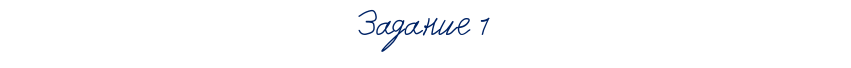

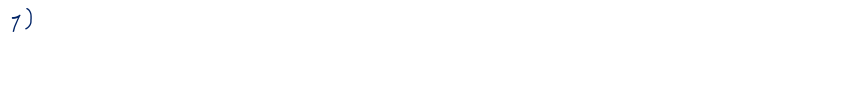

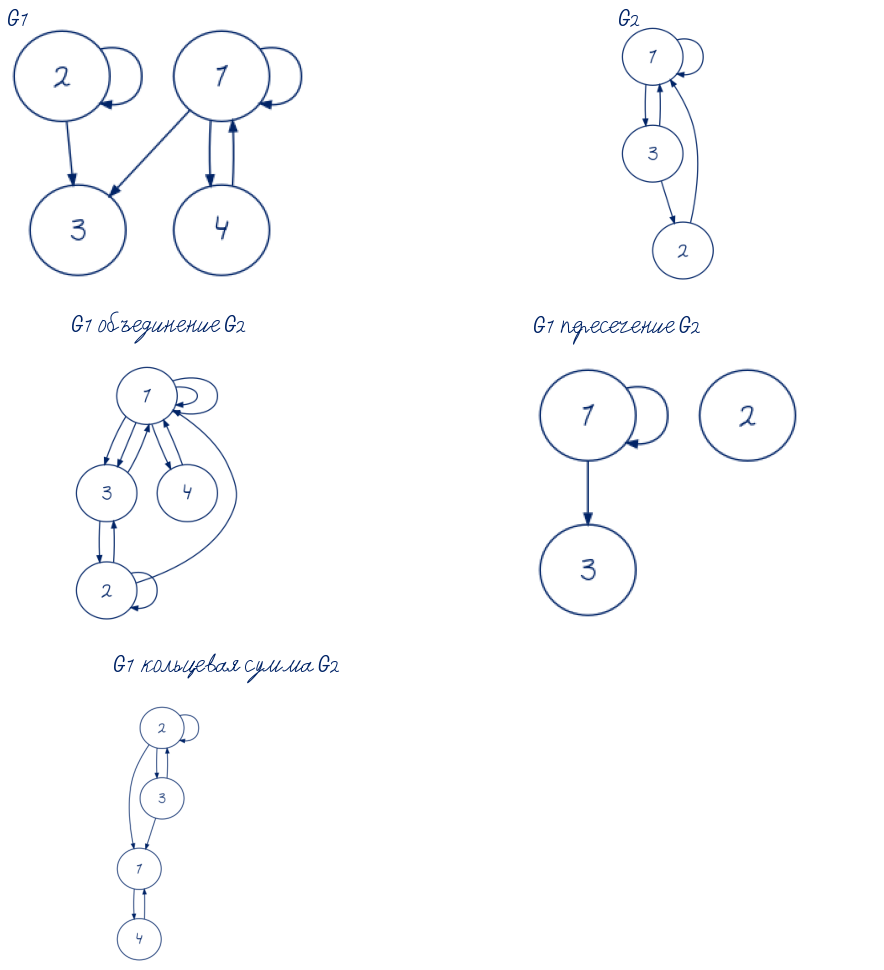

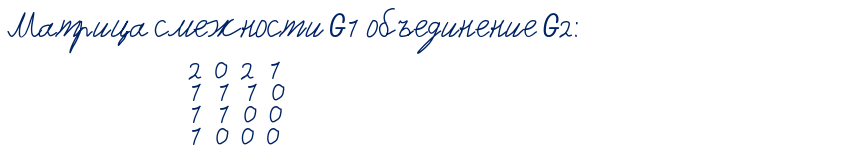

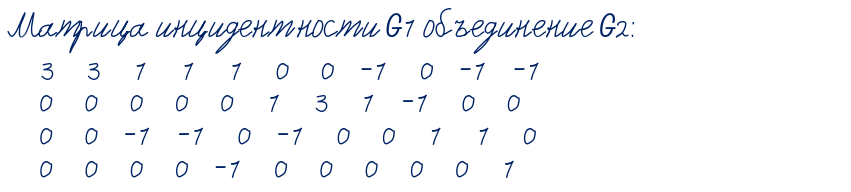

In [2]:
'''
    Задание 1
'''
fig, ax = plt.subplots(figsize=(15,1))
ax.axis('off')
ax.text(0.5, 0.5, 'Задание 1', horizontalalignment='center',
      fontproperties=font_prop, size=35, color='#002366')

# № 1
fig, ax = plt.subplots(figsize=(15, 1))
ax.axis('off')
ax.text(0, 1, '1)', horizontalalignment='center',
      fontproperties=font_prop, size=35, color='#002366')

V1 = range(1, 5)
V2 = range(1, 4)
E1 = [(1, 1), (1, 3), (1, 4), (2, 3), (4, 1), (2, 2)]
E2 = [(2, 1), (1, 3), (3, 2), (3, 1), (1, 1)]

exercise_1(V1, V2, E1, E2)

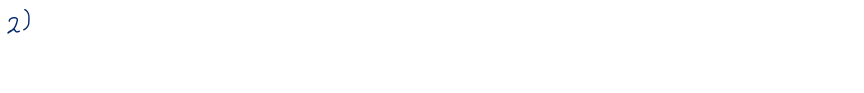

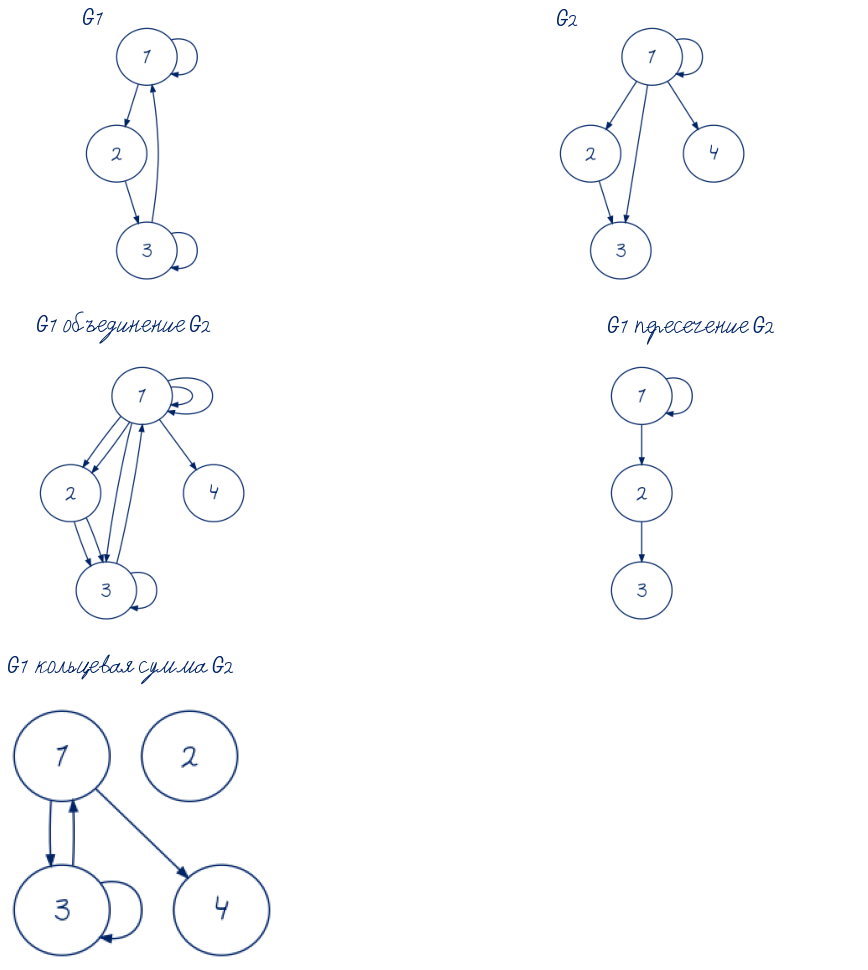

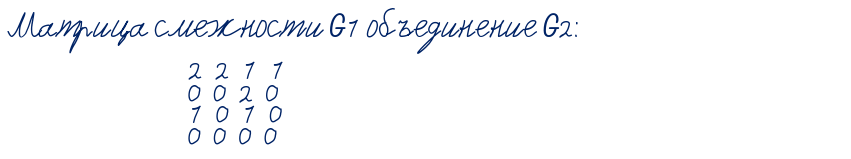

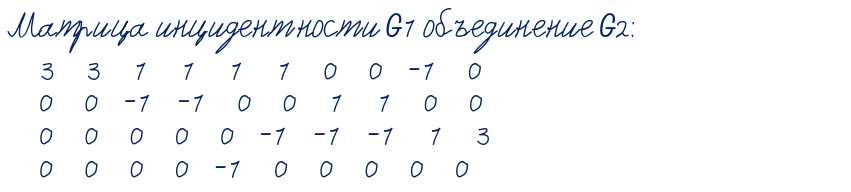

In [3]:
# № 2
fig, ax = plt.subplots(figsize=(15, 1))
ax.axis('off')
ax.text(0, 1, '2)', horizontalalignment='center',
      fontproperties=font_prop, size=35, color='#002366')

V1 = range(1, 4)
V2 = range(1, 5)
E1 = [(1, 1), (1, 2), (2, 3), (3, 1), (3, 3)]
E2 = [(1, 4), (1, 3), (1, 2), (1, 1), (2, 3)]

exercise_1(V1, V2, E1, E2)

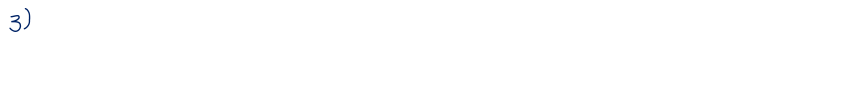

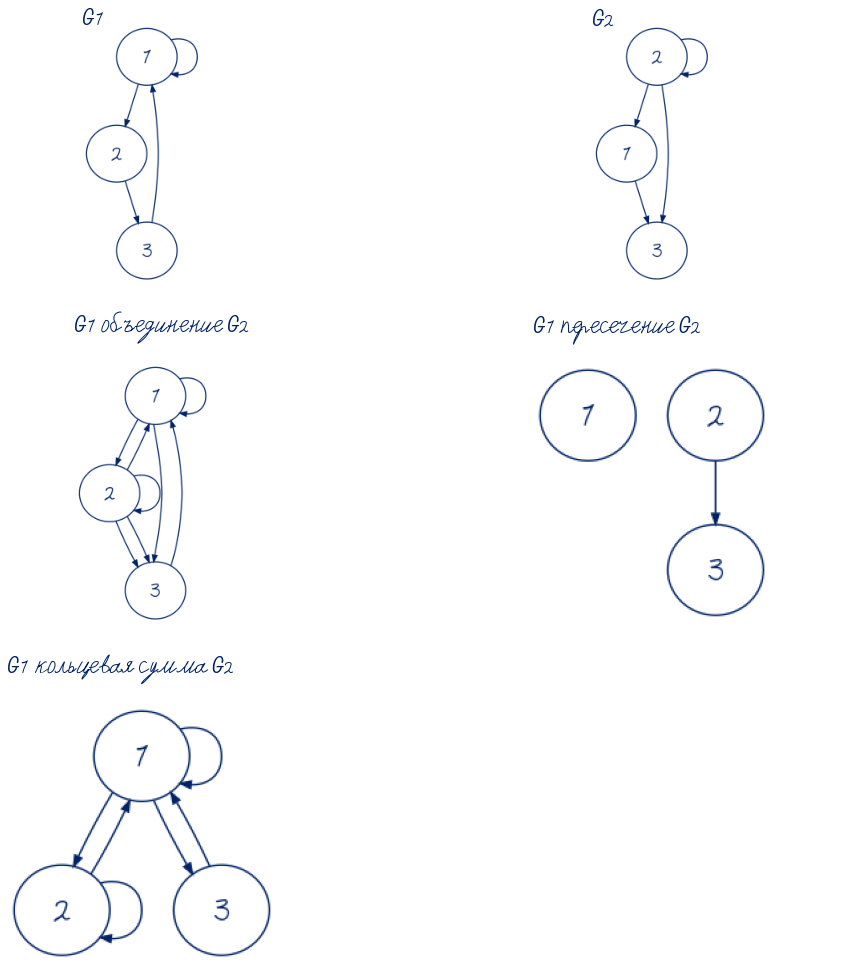

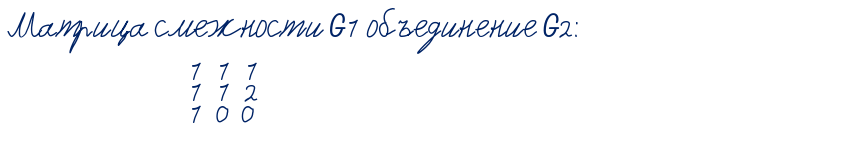

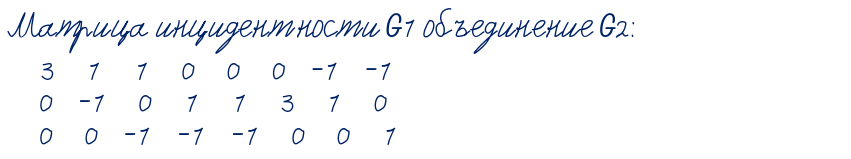

In [4]:
# № 3
fig, ax = plt.subplots(figsize=(15, 1))
ax.axis('off')
ax.text(0, 1, '3)', horizontalalignment='center',
      fontproperties=font_prop, size=35, color='#002366')

V1 = range(1, 4)
V2 = range(1, 4)
E1 = [(1, 1), (1, 2), (2, 3), (3, 1)]
E2 = [(2, 3), (2, 2), (2, 1), (1, 3)]

exercise_1(V1, V2, E1, E2)

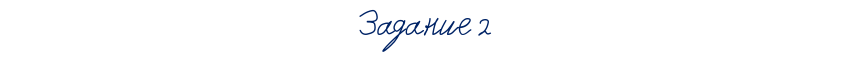

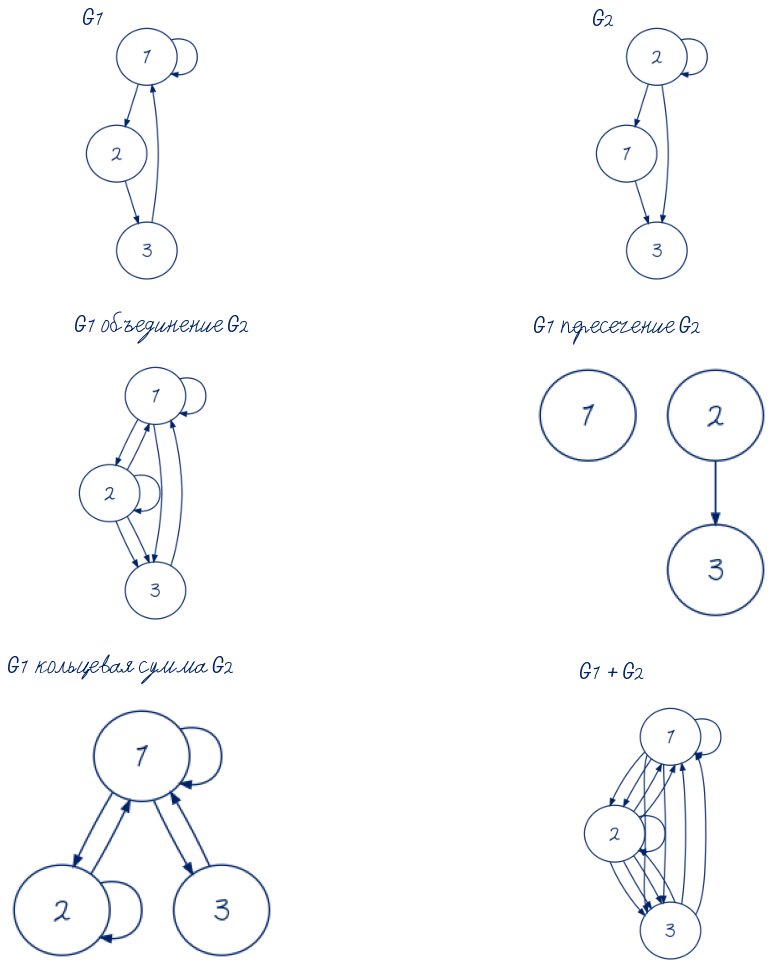

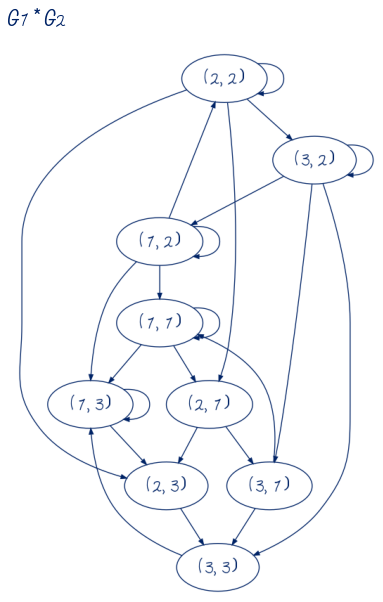

In [5]:
'''
    Задание 2
'''
fig, ax = plt.subplots(figsize=(15,1))
ax.axis('off')
ax.text(0.5, 0.5, 'Задание 2', horizontalalignment='center',
      fontproperties=font_prop, size=35, color='#002366')

V1 = [1, 2, 3]
V2 = [1, 2, 3]
E1 = [(1, 1), (1, 2), (2, 3), (3, 1)]
E2 = [(2, 3), (2, 2), (2, 1), (1, 3)]

exercise_2(V1, V2, E1, E2)

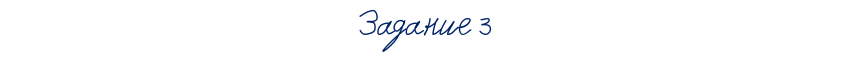

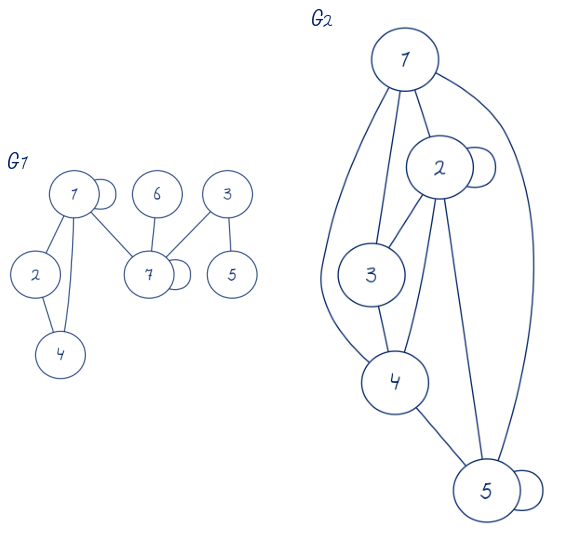

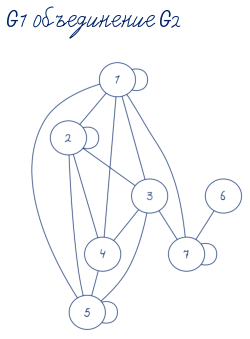

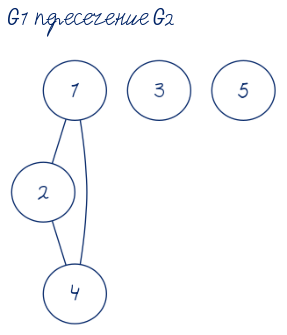

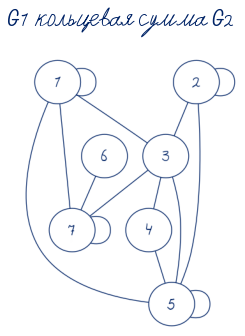

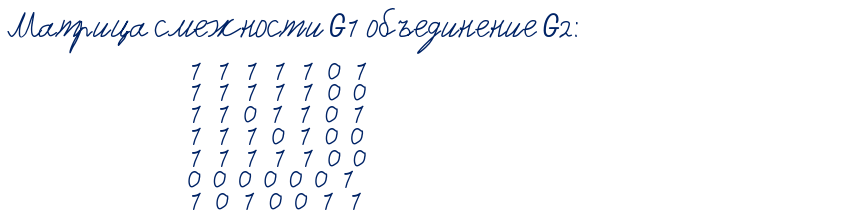

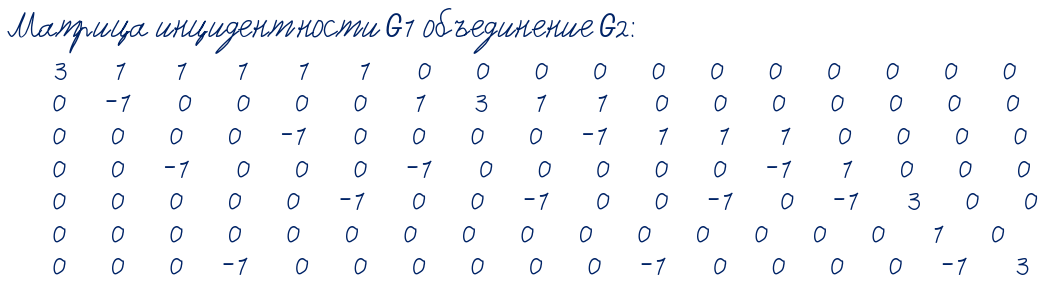

In [6]:
'''
    Задание 3
'''
fig, ax = plt.subplots(figsize=(15,1))
ax.axis('off')
ax.text(0.5, 0.5, 'Задание 3', horizontalalignment='center',
      fontproperties=font_prop, size=35, color='#002366')

G1 = graph_from_incidence_matrix([
    [3,1,0,1,0,0,0,0,1],
    [0,1,0,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0,0],
    [0,0,0,1,1,0,0,0,0],
    [0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,1,0,0],
    [0,0,1,0,0,0,1,3,1],
])

G2 = graph_from_adjacency_matrix([
    [0,0,1,1,1],
    [1,1,0,0,1],
    [1,1,0,1,0],
    [0,1,1,0,0],
    [0,0,0,1,1],
])

V1 = G1.nodes
V2 = G2.nodes
E1 = list(G1.edges)
E2 = list(G2.edges)

exercise_3(V1, V2, E1, E2)